In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
# === 1. Grille fournie par l'utilisateur ===
def get_env():
    return np.array([
        [0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2],
        [0, 0, 1, 1, 0, 1, 2, 2, 0, 2, 2],
        [0, 0, 0, 1, 0, 1, 2, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        [3, 0, 0, 1, 1, 0, 2, 1, 0, 0, 4],
        [0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 2, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 2],
        [0, 0, 2, 2, 0, 0, 1, 0, 2, 0, 0],
        [0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    ])


In [ ]:
# === 2. Paramètres Q-learning ===
actions = [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]  # Déplacements possibles : haut, bas, gauche, droite, et diagonales
alpha = 0.5    # Taux d'apprentissage
gamma = 0.9    # Facteur de réduction


In [ ]:
# === 3. Fonctions utilitaires ===
def is_valid(pos, env):
    x, y = pos
    return 0 <= x < env.shape[0] and 0 <= y < env.shape[1]  # Vérifie si la position est à l'intérieur des limites de la grille


In [ ]:
def is_diagonal(dx, dy):
    return abs(dx) + abs(dy) == 2  # Vérifie si le déplacement est diagonal (par exemple : (-1, -1), (1, 1), etc.)


In [ ]:
def move_cost(env, current, target, dx, dy):
    # Si la case cible est invalide ou un mur (valeur 1), retourne un coût élevé (mais mouvement permis)
    if not is_valid(target, env) or env[target] == 1:
        return 1.41 if is_diagonal(dx, dy) else 1
    # Si la case est de l'eau (valeur 2), le déplacement est plus coûteux
    elif env[target] == 2:
        return 4.24 if is_diagonal(dx, dy) else 3
    # Sinon, le coût est standard (diagonal ou orthogonal)
    return 1.41 if is_diagonal(dx, dy) else 1


* The move_cost function calculates the cost of moving from the current cell to a target cell in the grid.
* It depends on two things:
   * What is in the target cell (wall, water, or free space)
   *  How you are moving (diagonal or straight)

In [ ]:
def get_reward(env, pos):
    # Si la position est invalide (en dehors de la grille), on retourne une pénalité importante
    if not is_valid(pos, env): return -5
    # Si la position correspond à la cible (valeur 4), on donne une grosse récompense
    if env[pos] == 4: return 100
    # Si la position est de l'eau (valeur 2), pénalité moyenne
    if env[pos] == 2: return -3
    # Sinon, petite pénalité pour inciter à trouver rapidement la cible
    return -0.5


* The get_reward function gives a "reward" or "penalty" based on what is in the cell where the agent is currently standing.
* It helps guide the agent's behavior:

   * Big rewards if doing something good ✅

   * Penalties if doing something bad ❌

In [ ]:
def find_start_goal(env):
    # Trouve la position de départ (valeur 3) sous forme de tuple (ligne, colonne)
    start = tuple(map(int, np.argwhere(env == 3)[0]))
    # Trouve la position de l'objectif (valeur 4) sous forme de tuple (ligne, colonne)
    goal = tuple(map(int, np.argwhere(env == 4)[0]))
    return start, goal


In [ ]:
# === 4. Apprentissage Q-learning  ===
def train_q_learning(env, episodes=1000):
    # Initialisation de la matrice Q avec des zéros, une dimension pour chaque cellule et chaque action possible
    Q = np.zeros((*env.shape, len(actions)))
    # Récupère les coordonnées de départ et d’arrivée
    start, goal = find_start_goal(env)
    # Démarre le chronomètre pour mesurer la durée d’apprentissage
    start_time = time.time()

    # Boucle principale sur les épisodes d'entraînement
    for _ in range(episodes):
        state = start
        # Chaque épisode permet à l'agent d’effectuer jusqu’à 500 mouvements
        for _ in range(500):
            if state == goal:
                break  # Arrête si l’objectif est atteint

            x, y = state
            # Sélectionne la meilleure action actuelle (greedy)
            action_idx = np.argmax(Q[x, y])
            dx, dy = actions[action_idx]
            tentative = (x + dx, y + dy)

            # Vérifie si le mouvement est valide et pas un mur
            if is_valid(tentative, env) and env[tentative] != 1:
                new_state = tentative
            else:
                new_state = state  # Si invalide, reste sur place

            # Calcule le coût de déplacement et la récompense
            cost = move_cost(env, state, new_state, dx, dy)
            reward = get_reward(env, new_state)
            nx, ny = new_state

            # Met à jour la valeur Q pour l’état-action courante
            Q[x, y, action_idx] = (1 - alpha) * Q[x, y, action_idx] + alpha * (
                reward - cost + gamma * np.max(Q[nx, ny])
            )
            state = new_state  # Passe à l’état suivant

    # Calcule la durée totale d’entraînement
    duration = time.time() - start_time
    return Q, duration  # Retourne la matrice Q entraînée et la durée


* This function trains an agent using Q-learning so that it learns how to reach the goal in the environment as quickly and efficiently as possible.
* It builds and updates a table (called the Q-table) that stores the "goodness" of each action at every position.

* The idea:

   * "Which action should I take at this place to reach the goal with the best reward and the lowest cost?"

In [ ]:
# === 5. Extraire le chemin optimal ===
def extract_path(Q, env):
    # Récupère les positions de départ et d’arrivée
    start, goal = find_start_goal(env)
    state = start
    path = [state]  # Initialise le chemin avec la position de départ
    total_cost = 0  # Initialise le coût total du chemin

    # Limite à 100 étapes pour éviter les boucles infinies
    for _ in range(100):
        if state == goal:
            break  # Arrête si l’objectif est atteint

        x, y = state
        # Choisit la meilleure action possible à partir de la Q-table
        action_idx = np.argmax(Q[x, y])
        dx, dy = actions[action_idx]
        tentative = (x + dx, y + dy)

        # Vérifie la validité du mouvement et si ce n'est pas un mur
        if is_valid(tentative, env) and env[tentative] != 1:
            new_state = tentative
        else:
            new_state = state  # Si mouvement invalide, reste en place

        # Ajoute le coût de déplacement au total
        total_cost += move_cost(env, state, new_state, dx, dy)
        path.append(new_state)  # Ajoute la nouvelle position au chemin

        if new_state == state:
            break  # Si bloqué (aucun mouvement possible), arrête

        state = new_state  # Met à jour l’état actuel

    return path, total_cost  # Retourne le chemin optimal et son coût total


* This function uses the trained Q-table to extract the best path the agent should take from the start to the goal, based on what it learned during training.

* In short:
  * "Now that the agent has learned, let's follow its best decisions to draw the shortest/best path!"

In [ ]:
# === 6. Affichage graphique ===
def show_grid(env, path):
    fig, ax = plt.subplots(figsize=(9, 9))
    colors = {0: 'white', 1: 'gray', 2: 'blue', 3: 'red', 4: 'green'}

    # Draw the environment cells
    for i in range(env.shape[0]):
        for j in range(env.shape[1]):
            color = colors.get(env[i, j], 'white')
            ax.add_patch(plt.Rectangle((j, env.shape[0]-i-1), 1, 1, color=color, edgecolor='black'))

    # Plot the path
    for (i, j) in path:
        ax.plot(j + 0.5, env.shape[0] - i - 0.5, 'o', color='yellow')

    # Set the limits
    ax.set_xlim(0, env.shape[1])
    ax.set_ylim(0, env.shape[0])
    ax.set_aspect('equal')

    # Set ticks at every cell
    ax.set_xticks(range(env.shape[1] + 1))
    ax.set_yticks(range(env.shape[0] + 1))

    # Show gridlines
    ax.grid(True, which='both', color='black', linewidth=1)

    # Show axes
    plt.xlabel("Columns")
    plt.ylabel("Rows")

    plt.title("🟡 Chemin trouvé par le robot")
    plt.show()


✅ Apprentissage terminé
📏 Nombre d'étapes : 19
💰 Coût total du chemin : 23.87
⏱️ Temps d'exécution : 0.36 secondes


<ipython-input-41-8de0092cfec5>:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, env.shape[0]-i-1), 1, 1, color=color, edgecolor='black'))


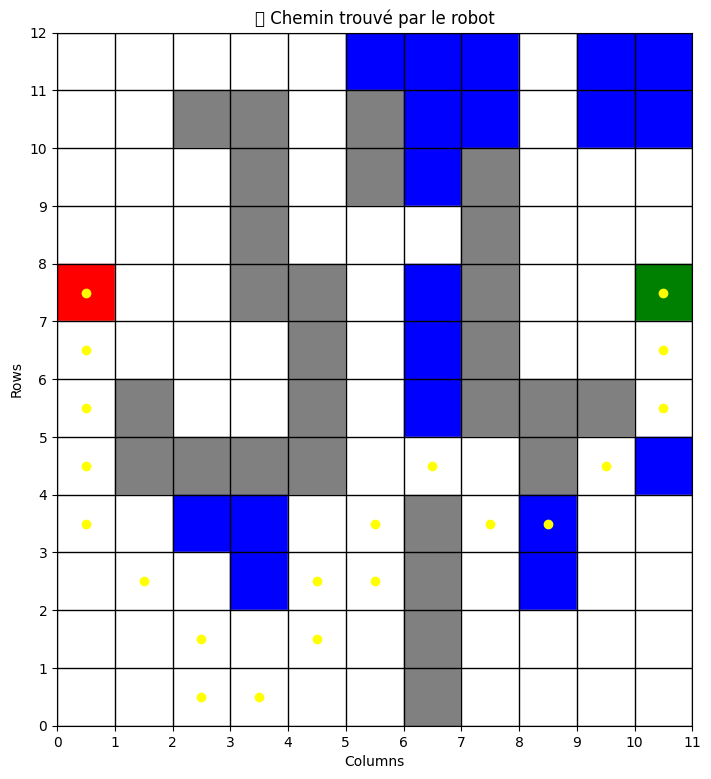

In [ ]:
# === 6. Affichage graphique ===
def show_grid(env, path):
    # Initialise une figure et un axe avec une taille 9x9
    fig, ax = plt.subplots(figsize=(9, 9))

    # Dictionnaire des couleurs selon les types de cellules
    colors = {0: 'white', 1: 'gray', 2: 'blue', 3: 'red', 4: 'green'}

    # Dessine chaque cellule de l'environnement
    for i in range(env.shape[0]):
        for j in range(env.shape[1]):
            color = colors.get(env[i, j], 'white')  # Récupère la couleur associée
            # Ajoute un rectangle coloré représentant la cellule
            ax.add_patch(plt.Rectangle((j, env.shape[0]-i-1), 1, 1, color=color, edgecolor='black'))

    # Trace le chemin trouvé sous forme de cercles jaunes
    for (i, j) in path:
        ax.plot(j + 0.5, env.shape[0] - i - 0.5, 'o', color='yellow')

    # Définit les limites de l’axe
    ax.set_xlim(0, env.shape[1])
    ax.set_ylim(0, env.shape[0])
    ax.set_aspect('equal')  # Garde des cellules carrées

    # Positionne les ticks pour chaque cellule
    ax.set_xticks(range(env.shape[1] + 1))
    ax.set_yticks(range(env.shape[0] + 1))

    # Active les lignes de la grille
    ax.grid(True, which='both', color='black', linewidth=1)

    # Ajoute des labels pour les axes
    plt.xlabel("Columns")
    plt.ylabel("Rows")

    # Titre de la figure
    plt.title("🟡 Chemin trouvé par le robot")

    # Affiche la figure finale
    plt.show()


**CHANGEMENT DES PARAMETRES:**

<ipython-input-30-8ed10c1192fb>:99: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, ROWS - i - 1), 1, 1, color=color, edgecolor='black'))


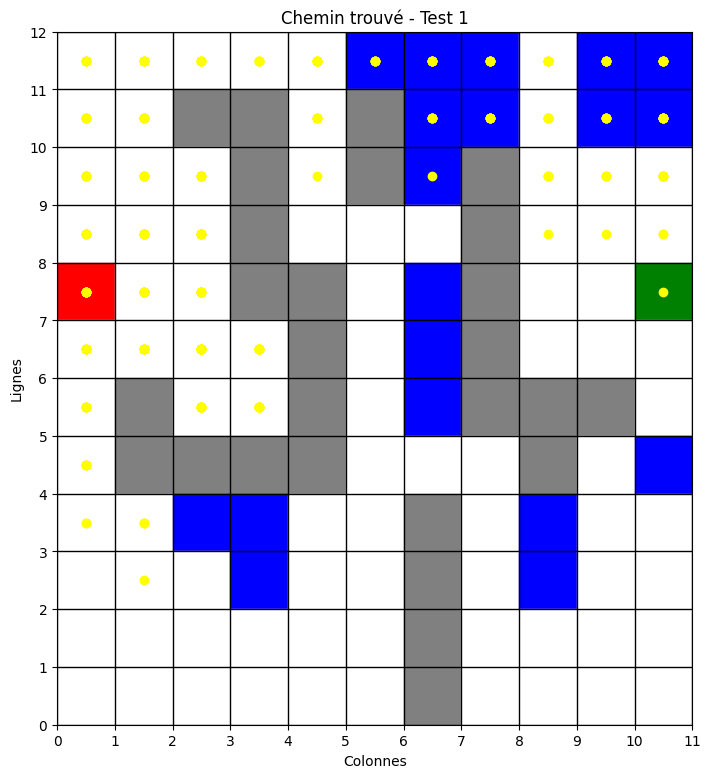

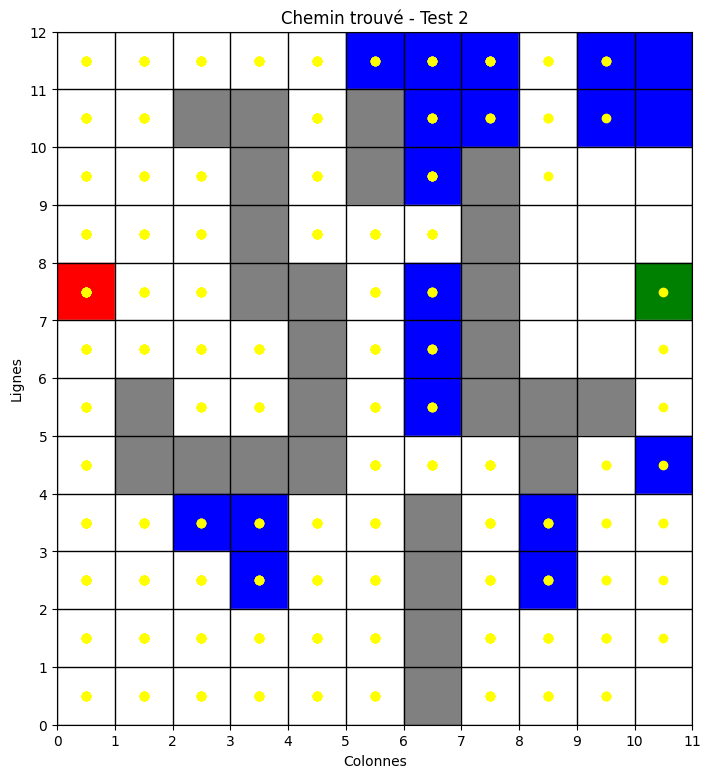

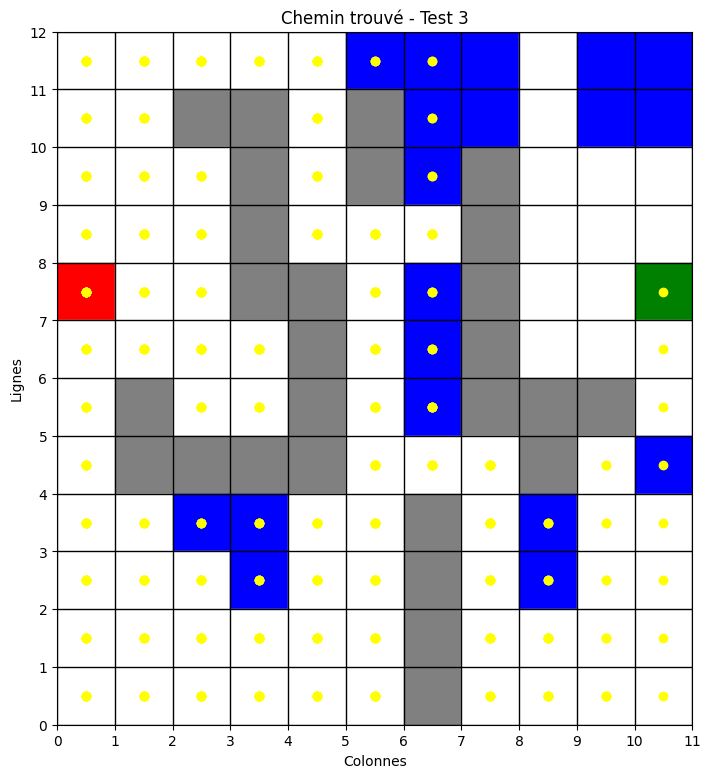

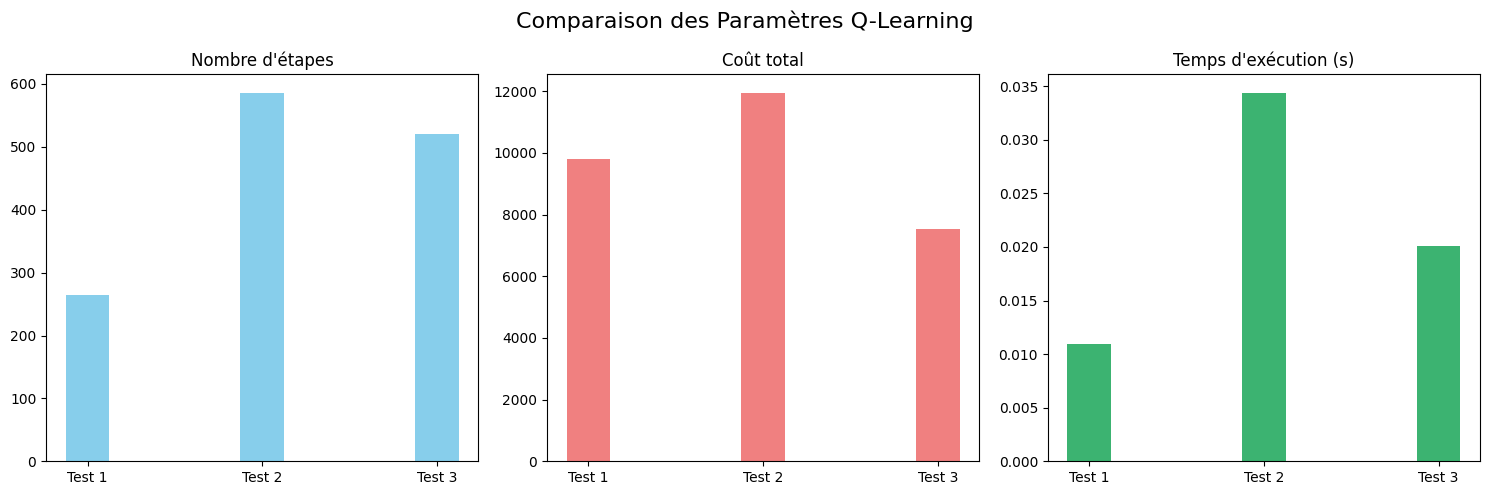

In [ ]:
# === Importation des bibliothèques nécessaires ===
import numpy as np
import matplotlib.pyplot as plt
import time

# === Définition de la grille de l'environnement ===
# 0: Libre | 1: Mur | 2: Eau | 3: Départ | 4: Arrivée
grille = [
    [0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2],
    [0, 0, 1, 1, 0, 1, 2, 2, 0, 2, 2],
    [0, 0, 0, 1, 0, 1, 2, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [3, 0, 0, 1, 1, 0, 2, 1, 0, 0, 4],
    [0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 2, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 2],
    [0, 0, 2, 2, 0, 0, 1, 0, 2, 0, 0],
    [0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
]
ROWS, COLS = len(grille), len(grille[0])  # Dimensions de la grille

# === Fonctions Utilitaires ===

# Fonction pour localiser les positions de départ (3) et d'arrivée (4)
def get_start_end(grille):
    start = end = None
    for r in range(ROWS):
        for c in range(COLS):
            if grille[r][c] == 3:
                start = (r, c)
            elif grille[r][c] == 4:
                end = (r, c)
    return start, end

# Fonction principale d'apprentissage Q-Learning
def q_learning(grille, alpha, gamma, reward_wall=-100, reward_water=-10, reward_goal=100):
    q_table = np.zeros((ROWS, COLS, 4))  # 4 actions possibles : haut, bas, gauche, droite
    start, end = get_start_end(grille)

    actions = [(-1,0), (1,0), (0,-1), (0,1)]  # Deltas pour mouvements
    nb_steps = 0
    cost_total = 0
    path = []

    start_time = time.time()  # Temps de début d'exécution
    state = start
    path.append(state)

    # Boucle jusqu'à atteindre la case d'arrivée
    while state != end:
        r, c = state

        # Choisir l'action : exploration aléatoire ou exploitation de la Q-table
        if np.random.uniform(0, 1) < 0.1:
            action_idx = np.random.choice(4)
        else:
            action_idx = np.argmax(q_table[r, c])

        dr, dc = actions[action_idx]
        new_r, new_c = r + dr, c + dc

        # Vérifier si le déplacement sort de la grille
        if not (0 <= new_r < ROWS and 0 <= new_c < COLS):
            reward = -100
            new_r, new_c = r, c  # Rester sur place
        else:
            cell = grille[new_r][new_c]
            if cell == 1:  # Mur
                reward = reward_wall
                new_r, new_c = r, c
            elif cell == 2:  # Eau
                reward = reward_water
            elif cell == 4:  # Objectif
                reward = reward_goal
            else:  # Cellule libre
                reward = -1

        # Mise à jour de la Q-table
        old_q = q_table[r, c, action_idx]
        next_max = np.max(q_table[new_r, new_c])
        q_table[r, c, action_idx] = old_q + alpha * (reward + gamma * next_max - old_q)

        # Mise à jour de l'état
        state = (new_r, new_c)
        path.append(state)
        nb_steps += 1
        cost_total += abs(reward)

        if nb_steps > 1000:  # Sécurité pour éviter boucles infinies
            break

    end_time = time.time()  # Temps de fin d'exécution
    exec_time = end_time - start_time

    return nb_steps, cost_total, exec_time, path

# === Fonction d'affichage de la grille et du chemin ===
def show_grid(grille, path, title="Chemin"):
    fig, ax = plt.subplots(figsize=(9, 9))
    colors = {0: 'white', 1: 'gray', 2: 'blue', 3: 'red', 4: 'green'}

    # Dessiner chaque cellule
    for i in range(ROWS):
        for j in range(COLS):
            color = colors.get(grille[i][j], 'white')
            ax.add_patch(plt.Rectangle((j, ROWS - i - 1), 1, 1, color=color, edgecolor='black'))

    # Dessiner le chemin suivi (points jaunes)
    for (i, j) in path:
        ax.plot(j + 0.5, ROWS - i - 0.5, 'o', color='yellow')

    ax.set_xlim(0, COLS)
    ax.set_ylim(0, ROWS)
    ax.set_aspect('equal')
    ax.set_xticks(range(COLS + 1))
    ax.set_yticks(range(ROWS + 1))
    ax.grid(True, which='both', color='black', linewidth=1)
    plt.title(title)
    plt.xlabel('Colonnes')
    plt.ylabel('Lignes')
    plt.show()

# === Tests avec différents paramètres ===

# Liste de tests avec différentes valeurs de alpha, gamma, et punitions
param_tests = [
    {"alpha": 0.9, "gamma": 0.95, "wall": -300, "water": -1},   # Objectif rapide, murs très punis
    {"alpha": 0.5, "gamma": 0.5, "wall": -100, "water": -50},   # Équilibré mais sévère avec le mur
    {"alpha": 0.1, "gamma": 0.9, "wall": -10,  "water": -100}   # Peur extrême de l'eau
]

results = []  # Stocker nombre d'étapes, coût total et temps d'exécution
paths = []    # Stocker chemins trouvés

# Lancer chaque test
for i, params in enumerate(param_tests):
    steps, cost, timing, path = q_learning(
        grille,
        alpha=params["alpha"],
        gamma=params["gamma"],
        reward_wall=params["wall"],
        reward_water=params["water"]
    )
    results.append((steps, cost, timing))
    paths.append(path)

    # Afficher la grille avec le chemin pour chaque expérience
    show_grid(grille, path, title=f"Chemin trouvé - Test {i+1}")

# === Comparaison graphique des résultats ===

labels = ["Test 1", "Test 2", "Test 3"]
steps = [r[0] for r in results]
costs = [r[1] for r in results]
timings = [r[2] for r in results]

x = np.arange(len(labels))  # Positions des barres
width = 0.25  # Largeur des barres

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Graphique : Nombre d'étapes
axs[0].bar(x, steps, width, color='skyblue')
axs[0].set_title('Nombre d\'étapes')
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels)

# Graphique : Coût total
axs[1].bar(x, costs, width, color='lightcoral')
axs[1].set_title('Coût total')
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels)

# Graphique : Temps d'exécution
axs[2].bar(x, timings, width, color='mediumseagreen')
axs[2].set_title('Temps d\'exécution (s)')
axs[2].set_xticks(x)
axs[2].set_xticklabels(labels)

plt.suptitle("Comparaison des Paramètres Q-Learning", fontsize=16)
plt.tight_layout()
plt.show()


> We have a robot on a map filled with walls and water.
The robot starts not knowing how to move.

> It tries randomly, sometimes hitting walls or drowning in water.

> Each time, it remembers how good or bad the move was in its Q-table.

> Over time, it learns a better path to reach the goal faster and smarter.

> We test three versions of the robot with different fears (more afraid of water, more afraid of walls, or balanced).

>Finally, we show the different performances with nice graphs